In [13]:
!pip install transformers
!pip install nlp
!pip install graphviz
!pip install pydot

In [14]:
## importing packages
import gc
import os
import random
import transformers
import warnings

import numpy as np
import nlp
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
import sklearn
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from transformers import AutoTokenizer, TFAutoModel
from sklearn.model_selection import train_test_split
from keras.utils import plot_model

In [15]:
# Code for using TPU at Kaggle
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

In [16]:
def load_data(train_paths, test_paths=None):
    train_data = []
    test_data=[]
    for path_string in train_paths:
        path = Path(path_string)
        data = pd.read_csv(path)
        train_data.append(data)
    if test_paths:
        
        for path_string in test_paths:
            path = Path(path_string)
            data = pd.read_csv(path)
            test_data.append(data)
    
    return train_data, test_data


In [17]:
## defining configuration
class Configuration():
    """
    All configuration for running an experiment
    """
    def __init__(
        self,
        model_name,
        file_name="model",
        max_length = 64,
        padding = True,
        batch_size = 128,
        epochs = 5,
        learning_rate = 1e-5,
        metrics = ["sparse_categorical_accuracy"],
        verbose = 1,
        random_seed = 42
    ):
        self.strategy = strategy
        self.name = file_name
        # seed
        self.SEED = random_seed

        # model configuration
        self.MODEL_NAME = model_name
        self.TOKENIZER = AutoTokenizer.from_pretrained(self.MODEL_NAME)

        # model hyperparameters
        self.MAX_LENGTH = max_length
        self.PAD_TO_MAX_LENGTH = padding
        self.BATCH_SIZE = batch_size
        self.EPOCHS = epochs
        self.LEARNING_RATE = learning_rate
        self.METRICS = metrics
        self.VERBOSE = verbose
 
        # defining replicas
        self.AUTO = tf.data.experimental.AUTOTUNE
        self.REPLICAS = strategy.num_replicas_in_sync
        print(f"REPLICAS: {self.REPLICAS}")

In [18]:
def encode_text(text, tokenizer, max_len, padding):
    """
    Preprocessing textual data into encoded tokens.
    """
    strings = text
    # encoding text using tokenizer of the model
    text_encoded = tokenizer.batch_encode_plus(
        strings,
        pad_to_max_length=padding,
        max_length=max_len,
        truncation=True
    )

    return text_encoded


def get_tf_dataset(X, y, auto, labelled = True, repeat = False, shuffle = False, batch_size = 128):
    """
    Creating tf.data.Dataset of the input data to be fed to the network.
    https://www.tensorflow.org/api_docs/python/tf/data/Dataset
    """
    if labelled:
        ds = (tf.data.Dataset.from_tensor_slices((X["input_ids"], y)))
    else:
        ds = (tf.data.Dataset.from_tensor_slices(X["input_ids"]))

    if repeat:
        ds = ds.repeat()

    if shuffle:
        ds = ds.shuffle(2048)

    ds = ds.batch(batch_size)
    ds = ds.prefetch(auto) # Increase performance by prefetching data

    return ds

In [19]:
def build_model(model_name, max_len, learning_rate, metrics):
    """
    Building the Deep Learning architecture
    """
    # defining encoded inputs
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    
    # defining transformer model embeddings
    transformer_model = TFAutoModel.from_pretrained(model_name)
    transformer_embeddings = transformer_model(input_ids)[0]

    # defining output layer
    output_values = Dense(3, activation = "softmax")(transformer_embeddings[:, 0, :])

    # defining model
    model = Model(inputs = input_ids, outputs = output_values)
    optimizer = Adam(learning_rate = learning_rate)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    plot_model(model, to_file='model.png', show_shapes=True,show_layer_names=True)

    return model

In [20]:

def run_model(config, train_dataframe, test_dataframe):
    """
    Running the model
    """
    

    K.clear_session()
    # building model
    with config.strategy.scope():
        model = build_model(config.MODEL_NAME, config.MAX_LENGTH, config.LEARNING_RATE, config.METRICS)
        print(model.summary())

        # split the data into training and validation 
        X_train, X_valid, y_train, y_valid = train_test_split(train_dataframe[['premise', 'hypothesis']].values.tolist(),
                                                  train_dataframe['label'], test_size=0.2, random_state=config.SEED)

        print("\nTokenizing")

        # encoding text data using tokenizer
        X_train_encoded = encode_text(text=X_train, tokenizer=config.TOKENIZER, max_len=config.MAX_LENGTH, padding=config.PAD_TO_MAX_LENGTH)
        X_valid_encoded = encode_text(text=X_valid, tokenizer=config.TOKENIZER, max_len=config.MAX_LENGTH, padding=config.PAD_TO_MAX_LENGTH)
        X_test_encoded = encode_text(text=test_dataframe[['premise', 'hypothesis']].values.tolist(), tokenizer=config.TOKENIZER, max_len=config.MAX_LENGTH, padding=config.PAD_TO_MAX_LENGTH)
        
        # creating TF Dataset
        ds_train = get_tf_dataset(X_train_encoded, y_train, config.AUTO, repeat=True, shuffle=True, batch_size=config.BATCH_SIZE * config.REPLICAS)
        ds_valid = get_tf_dataset(X_valid_encoded, y_valid, config.AUTO, batch_size=config.BATCH_SIZE * config.REPLICAS * 4)
        
        n_train = len(X_train)
        
       
        # saving model at best accuracy epoch
        filepath = config.name + ".h5"
        sv = tf.keras.callbacks.ModelCheckpoint(
            filepath,
            monitor = "val_sparse_categorical_accuracy",
            verbose = 0,
            save_best_only = True,
            save_weights_only = True,
            mode = "max",
            save_freq = "epoch"
        )

        print("\nTraining")

        # training model
        model_history = model.fit(
            ds_train,
            epochs = config.EPOCHS,
            callbacks = [sv],
            steps_per_epoch = n_train / config.BATCH_SIZE // config.REPLICAS,
            validation_data = ds_valid,
            verbose = config.VERBOSE
        )
        # Save history
        history_df = pd.DataFrame(model_history.history)
        json_file_path = config.name + ".json"
        with open(json_file_path, mode='w') as f:
            history_df.to_json(f)

        print("\nValidating")

        # scoring validation data
        model.load_weights(filepath)
        ds_valid = get_tf_dataset(X_valid_encoded, -1, config.AUTO, labelled = False, batch_size = config.BATCH_SIZE * config.REPLICAS * 4)

        preds_valid = model.predict(ds_valid, verbose = config.VERBOSE)
        acc = accuracy_score(y_valid, np.argmax(preds_valid, axis = 1))
        print(f"Accuracy: {round(acc, 4)}\n")


        print("\nInferencing")

        # scoring test data
        ds_test = get_tf_dataset(X_test_encoded, -1, config.AUTO, labelled = False, batch_size = config.BATCH_SIZE * config.REPLICAS * 4)
        
        # Predictions saved in "submission.csv". To use outside of Kaggle competition a scoring system must be implemented.
        predictions = [np.argmax(i) for i in model.predict(ds_test)]
        submission = test_dataframe.id.copy().to_frame()
        submission['prediction'] = predictions
        print(submission.head())
        submission.to_csv("submission.csv", index = False)

        
        g = gc.collect()


    return predictions

Average premise length: 107.37318481848185
Average Hypothesislength: 53.89232673267327


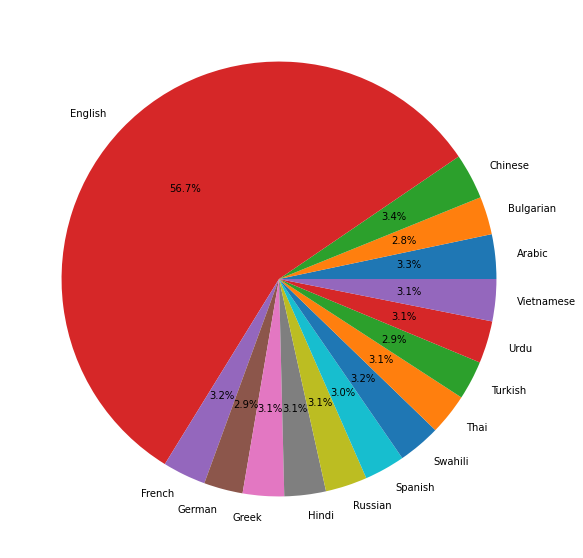

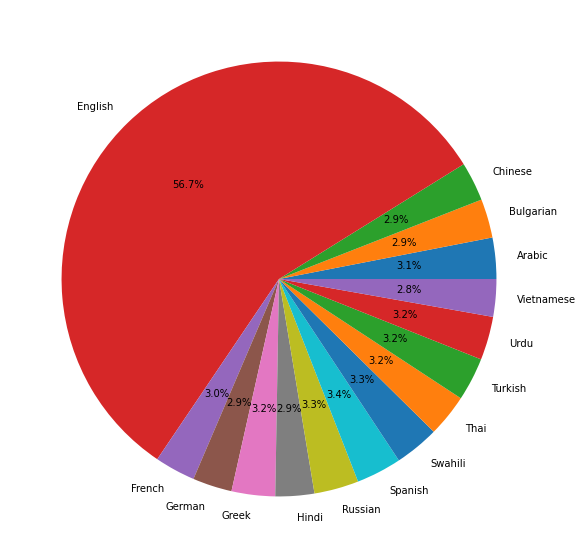

In [9]:
# Dear-watson dataset

train_paths = ['/kaggle/input/contradictory-my-dear-watson/train.csv']
test_paths = ["/kaggle/input/contradictory-my-dear-watson/test.csv"]
train_data, test_data = load_data(train_paths, test_paths)

train_data = sklearn.utils.shuffle(train_data[0].drop_duplicates())

# Average length of train premise sentence
sents = train_data.premise.values.tolist()
total_len_pred = 0
for s in sents:
    total_len_pred += len(s)
print(f"Average premise length: {total_len_pred/len(sents)}")

sents = train_data.hypothesis.values.tolist()
total_len_hyp = 0
for s in sents:
    total_len_hyp += len(s)
print(f"Average Hypothesislength: {total_len_hyp/len(sents)}")
del sents

# Plot language distribution in train and test data
labels, frequencies = np.unique(train_data.language.values, return_counts = True)
plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.savefig("langfreq.png")
plt.show()

labels, frequencies = np.unique(test_data[0].language.values, return_counts = True)
plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.savefig("langfreqtest.png")
plt.show()



In [ ]:
# The XLM-R Large model giving the best results, excep if using a model already finetuned on XNLI
config_1 = Configuration("jplu/tf-xlm-roberta-large", file_name="xlm-r-large-watson", max_length=84, batch_size=64, epochs=16)
preds_train_1 = run_model(config_1, train_data, test_data[0])


REPLICAS: 8


Some layers from the model checkpoint at jplu/tf-xlm-roberta-large were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 84)]              0         
_________________________________________________________________
tfxlm_roberta_model (TFXLMRo TFBaseModelOutputWithPool 559890432 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3075      
Total params: 559,893,507
Trainable params: 559,893,507
Non-trainable params: 0
_________________________________________________________________
None

Tokenizing


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



Training
Epoch 1/16


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


18/18 [==============================] - 181s 2s/step - loss: 1.6686 - sparse_categorical_accuracy: 0.3166 - val_loss: 1.1550 - val_sparse_categorical_accuracy: 0.3288
Epoch 2/16
18/18 [==============================] - 12s 654ms/step - loss: 1.2145 - sparse_categorical_accuracy: 0.3288 - val_loss: 1.1614 - val_sparse_categorical_accuracy: 0.3449
Epoch 3/16
18/18 [==============================] - 12s 655ms/step - loss: 1.1532 - sparse_categorical_accuracy: 0.3584 - val_loss: 1.0984 - val_sparse_categorical_accuracy: 0.3775
Epoch 4/16
18/18 [==============================] - 12s 653ms/step - loss: 1.1092 - sparse_categorical_accuracy: 0.3802 - val_loss: 1.0672 - val_sparse_categorical_accuracy: 0.4216
Epoch 5/16
18/18 [==============================] - 12s 655ms/step - loss: 1.1127 - sparse_categorical_accuracy: 0.3799 - val_loss: 1.0535 - val_sparse_categorical_accuracy: 0.4295
Epoch 6/16
18/18 [==============================] - 12s 656ms/step - loss: 1.0799 - sparse_categorical_accur

In [ ]:
#config_2 = Configuration("bert-base-multilingual-cased", file_name="bert-multi-watson", max_length=84, batch_size=64, epochs=16)
#results_2 =  run_model(config_2, train_data, test_data[0])

In [ ]:

# Dear-watson dataset and RoBERTa xnli

#train_paths = ['/kaggle/input/contradictory-my-dear-watson/train.csv']
#test_paths = ["/kaggle/input/contradictory-my-dear-watson/test.csv"]
#train_data, test_data = load_data(train_paths, test_paths)

#train_data = sklearn.utils.shuffle(train_data[0].drop_duplicates())


#config_1 = Configuration("joeddav/xlm-roberta-large-xnli", file_name="xlm-r-l-xnli-watson", max_length=84, batch_size=64, epochs=16)
#preds_train_1 = run_model(config_1, train_data, test_data[0])

In [ ]:
# Add XNLI Data

#train_paths = ["/kaggle/input/xnli-for-textual-entailment/train.csv", '/kaggle/input/contradictory-my-dear-watson/train.csv']
#test_paths = ["/kaggle/input/contradictory-my-dear-watson/test.csv"]
#train_data, test_data = load_data(train_paths, test_paths)
#train_data_1 = train_data[0].drop_duplicates()
#train_data_2 = train_data[1].drop(['id'], axis=1).drop_duplicates()

#labels, frequencies = np.unique(train_data_1.language.values, return_counts = True)
#plt.figure(figsize = (10,10))
#plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')

#plt.show()

#labels, frequencies = np.unique(train_data_2.language.values, return_counts = True)
#plt.figure(figsize = (10,10))
#plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
#plt.savefig("langfreq.png")
#plt.show()

#labels, frequencies = np.unique(test_data[0].language.values, return_counts = True)
#plt.figure(figsize = (10,10))
#plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
#plt.show()



#train_df = pd.concat([train_data_1, train_data_2])
#test_df = test_data[0]
#del train_data_1
#del train_data_2
#del train_data
#del test_data
#print(train_df.shape[0])
#print(test_df.shape[0])

#train_df = train_df.drop_duplicates(['premise', 'hypothesis'])
#print(train_df.shape[0])
#train_df[['hypothesis', 'premise']] = train_df[['hypothesis', 'premise']].astype(str)
#train_df = sklearn.utils.shuffle(train_df)

#test_df = train_df[300000:302000]
#train_df = train_df[:300000]



In [ ]:
#config_1 = Configuration("bert-base-multilingual-cased", file_name="xlm-r-base-xnli", max_length=84, batch_size=64, epochs=16)
#preds_train_1 = run_model(config_1, train_df, test_df)

In [ ]:
#config_2 = Configuration("jplu/tf-xlm-roberta-large", file_name="xlm-r-large-xnli", max_length=84, batch_size=64, epochs=16)
#preds_train_2 = run_model(config_2, train_df, test_df)